In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import torch
# from torch.autograd import Variable
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
# import torch.onnx

# from relaynet_pytorch.relay_net import ReLayNet
# from relaynet_pytorch.data_utils import get_imdb_data
# from helper import * # import helper functions

# from networks.relay_net import ReLayNet
# from networks.data_utils import get_imdb_data

# torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# For reading in datasets
# from torchvision.datasets import ImageFolder
# from torchvision import transforms, datasets

In [2]:
import os
cwd = os.getcwd() + '/datasets-24-aug/OCTData/alldata/'

In [3]:
# The values of the conversion by Elsa
values = [0.0, 0.007843138, 0.011764706, 0.015686275, 0.019607844, 0.023529412, 0.02745098]

In [4]:
import numpy
print (numpy.__version__)

1.15.1


(512, 600)


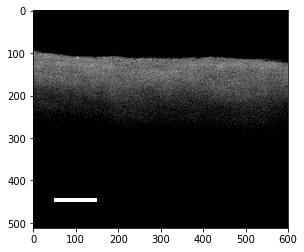

(512, 600, 3)


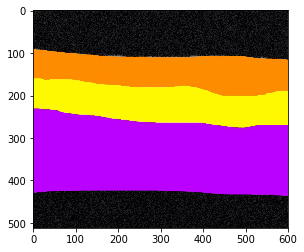

0 black
1 red
2 blue
3 purple
4 lime
5 orange
6 yellow
7 magenta
[0 3 5 7]
(512, 600)


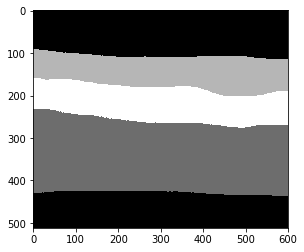

[0 1 3 5 7]
(512, 600)


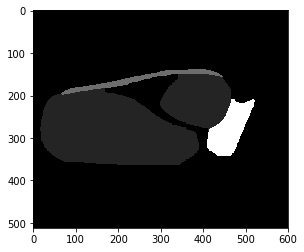

In [100]:
used_image = 3
if used_image == 1:
    image_file = 'whole_raw_image/con_H1_N01848_LV_1_194.tif'
    gnd_truth_image = 'manual_label/label_H1_N01848_LV_1_194.JPG'
    gnd_truth_label = 'png_labels_method/label_H1_N01848_LV_1_194_labels.png'
    result = 'labels_corrected/label_H1_N01848_LV_1_194_labelscorrected.png'
elif used_image == 2:
    image_file = 'whole_raw_image/con_H1_N01848_LA_1_272.tif'
    gnd_truth_image = 'manual_label/label_H1_N01848_LA_1_272.JPG'
    gnd_truth_label = 'png_labels_method/label_H1_N01848_LA_1_272_labels.png'
    result = 'labels_corrected/label_H1_N01848_LA_1_272_labelscorrected.png'
elif used_image == 3:
    image_file = 'whole_raw_image/con_H1_N01848_LA_1_272.tif'
    gnd_truth_image = 'manual_label/label_H1_N01848_LA_1_272.JPG'
    gnd_truth_label = 'png_labels_method/label_H1_N01848_LA_1_272_labels.png'
    result = 'labels_corrected/label_H1_N01848_LV_1_194_labelscorrected.png'
# Seeing whether image_file exists
raw_image_path = cwd + image_file
image = plt.imread(raw_image_path)
test_data = image    

print(test_data.shape)
plt.imshow(test_data,cmap = "gray")
# plt.imshow(test_data)
plt.show()

# Seeing whether labelled_image exists
label_image_path = cwd + gnd_truth_image
gnd_truth = plt.imread(label_image_path)
print(gnd_truth.shape)
plt.imshow(gnd_truth, cmap = "gray")
plt.show()

colors = [ 'black', 'red', 'blue', 'purple', 'lime', 'orange', 'yellow','magenta']
for count, i in enumerate(colors):
    print(count, i)
    
# Seeing whether result_image exists
gnd_truth_path = cwd + gnd_truth_label
gnd = plt.imread(gnd_truth_path)
gnd = ((gnd*7)/np.max(gnd)).astype(int)
print(np.unique(gnd))
print(gnd.shape)
plt.imshow(gnd,cmap = "gray")
plt.show()

# Seeing whether result_image exists
res_image_path = cwd + result
res = plt.imread(res_image_path)
res = ((res*7)/np.max(res)).astype(int)
print(np.unique(res))
print(res.shape)
plt.imshow(res,cmap = "gray")
plt.show()

# Metrics

File to generate metrics from each of the returned images.

* FP & FN
* Average Thickness of Layers - similar to MAD-LT below
* MAD-LT - error in estimated thickness map (ReLayNet Metric)
* DS - Dice Overlap Score (ReLayNet Metric)
* Distance (Euclidean) between Ground Truth and Where my Segments are - this is CE - Estimated contour error for each layer (ReLayNet Metric)

### TP, TN, FP, FN, Class Accuracy, Precision, Recall, F1

In [101]:
def list_of_labels(labels_list):
    val = 1
    h,w = labels_list.shape
    train_labels = np.zeros((h,w,8))
    for j in range(h) :
        for k in range(w):
            if(labels_list[j][k] == 0):
                train_labels[j][k][0] = val
            if(labels_list[j][k] == 1):
                train_labels[j][k][1] = val
            if(labels_list[j][k] == 2):
                train_labels[j][k][2] = val
            if(labels_list[j][k] == 3):
                train_labels[j][k][3] = val
            if(labels_list[j][k] == 4):
                train_labels[j][k][4] = val
            if(labels_list[j][k] == 5):
                train_labels[j][k][5] = val
            if(labels_list[j][k] == 6):
                train_labels[j][k][6] = val
            if(labels_list[j][k] == 7):
                train_labels[j][k][7] = val
    return train_labels
true_labels = list_of_labels(gnd)
pred_labels = list_of_labels(res)
# pred_labels = np.zeros((512,600,8))

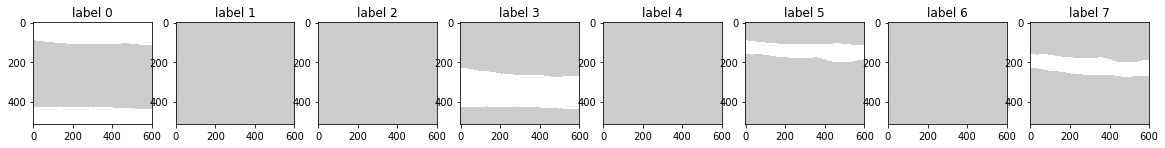

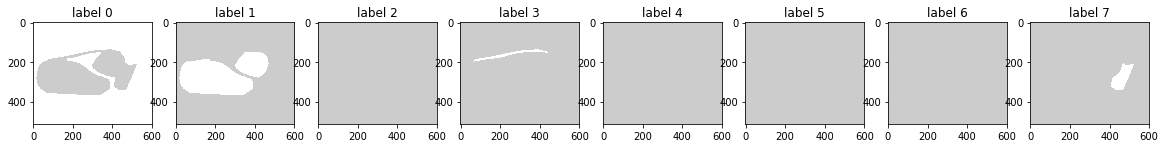

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20,20))
for i, ax in enumerate(axes):
    ax.imshow((true_labels[:,:,i]), alpha=0.2)
    ax.set_title("label " + str(i))
    
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20,20))
for i, ax in enumerate(axes):
    ax.imshow((pred_labels[:,:,i]), alpha=0.2)
    ax.set_title("label " + str(i))

In [105]:
num_classes = 8
class_vals = []
thresh = 0.0001

for i in range(num_classes):
    # NOTE: FOR MY CLASSES WITH MANY IMAGES - JUST ADD EXTRA DIMENSION TO pred_labels[x,:,:,i]
    # NOTE: if Precision etc are NaN, means there's no information about those classes in this image therefore remove them from analysis of that label

    # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
    TP = np.sum(np.logical_and(pred_labels[:,:,i] == 1, true_labels[:,:,i] == 1))
 
    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = np.sum(np.logical_and(pred_labels[:,:,i] == 0, true_labels[:,:,i] == 0))
 
    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = np.sum(np.logical_and(pred_labels[:,:,i] == 1, true_labels[:,:,i] == 0))
 
    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = np.sum(np.logical_and(pred_labels[:,:,i] == 0, true_labels[:,:,i] == 1))
    
    # Accuracy - no of correct predictions / all predictions
    Acc = round((TP + TN)/(TP + TN + FP + FN), 3)
    
    # Precision - number of True Positives divided by the number of True Positives and False Positives,
    # number of positive predictions divided by the total number of positive class values predicted
    Precision = round(TP / (TP + FP),3)
    
    # Recall - number of True Positives divided by the number of True Positives and the number of False Negatives. 
    # Number of positive predictions divided by the number of positive class values in the test data.
    Recall = round(TP / (TP + FN),3)
    
    # F1 Score - 2*((precision*recall)/(precision+recall)). 
    # F1 score conveys the balance between the precision and the recall.
    F1 = round(2 * (Precision * Recall) / (Precision + Recall + thresh), 3)
    

    
    print('Label:',i)

    print('TP: {}, FP: {}, TN: {}, FN: {}, Class Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(TP,FP,TN,FN,Acc, Precision, Recall, F1))
    print()
    class_vals.append((TP,FP,TN,FN,Acc,Precision,Recall,F1))
    
#     Dice = round(2 * TP / (2*TP+FP+FN),3)    
#     print('TP: {}, FP: {}, TN: {}, FN: {}, Class Accuracy: {}, Precision: {}, Recall: {}, F1: {}, Dice: {}'.format(TP,FP,TN,FN,Acc, Precision, Recall, F1, Dice))
#     class_vals.append((TP,FP,TN,FN,Acc,Precision,Recall,F1,Dice))
#     print()

Label: 0
TP: 114255, FP: 114197, TN: 78748, FN: 0, Class Accuracy: 0.628, Precision: 0.5, Recall: 1.0, F1: 0.667

Label: 1
TP: 0, FP: 66253, TN: 240947, FN: 0, Class Accuracy: 0.784, Precision: 0.0, Recall: nan, F1: nan

Label: 2
TP: 0, FP: 0, TN: 307200, FN: 0, Class Accuracy: 1.0, Precision: nan, Recall: nan, F1: nan

Label: 3
TP: 0, FP: 4242, TN: 201427, FN: 101531, Class Accuracy: 0.656, Precision: 0.0, Recall: 0.0, F1: 0.0

Label: 4
TP: 0, FP: 0, TN: 307200, FN: 0, Class Accuracy: 1.0, Precision: nan, Recall: nan, F1: nan

Label: 5
TP: 0, FP: 1, TN: 262815, FN: 44384, Class Accuracy: 0.856, Precision: 0.0, Recall: 0.0, F1: 0.0

Label: 6
TP: 0, FP: 0, TN: 307200, FN: 0, Class Accuracy: 1.0, Precision: nan, Recall: nan, F1: nan

Label: 7
TP: 3524, FP: 4728, TN: 255442, FN: 43506, Class Accuracy: 0.843, Precision: 0.427, Recall: 0.075, F1: 0.128



/Users/sim/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/Users/sim/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


### Average Thickness of Layers and Error in Thickness
Limitation of this is that if image has classified layer seperately from each other, will still give 1 average thickness score for that column but it's actually 2 different parts of a layer.

Assumption is layer will be mostly connecting

In [106]:
from skimage.measure import compare_ssim as ssim
N = 512
error_of_thickness = []
for i in range(8):
    # NOTE: IF AVERAGE_TIHCKNESS IS NAN, MEANS NOT IN THIS IMAGE
    true_thickness = []
    pred_thickness = []
    class_error = []
    # For each col, find thickness, compare to actual thickness and sum errors 
    for j in range(N):
        true_col = true_labels[:,j,i] # finding number of values in col, go down axis i.e. index of axis
        pred_col = pred_labels[:,j,i] 

        true_width = numpy.count_nonzero(true_col) # count number of 1s
        pred_width = numpy.count_nonzero(pred_col)
        
        # Finding thickness by looking at pred_width - don't need truth because will find error
        if true_width != 0:
            true_thickness.append(pred_width)
        if pred_width != 0:
            pred_thickness.append(pred_width)
        
        # If true width is not 0 or pred_width is not 0, append them otherwise there's no label for this image
        if true_width != 0 or pred_width != 0:
            abs_error = abs(pred_width - true_width) # error is pred - true
            class_error.append(abs_error)

    avg_true_thickness = np.average(true_thickness)
    avg_pred_thickness = np.average(pred_thickness)
    mean_abs_error = np.average(class_error)
    mean_squared_error = np.average(np.power(class_error,2))
    s = ssim(true_labels[:,:,i], pred_labels[:,:,i])
    print('Label: {} \nAverage True Thickness: {}' \
          '\nAverage Predicted Thickness: {}' \
          '\nMean Absolute Error of Thickness: {}'\
          '\nMean Squared Error of Thickness: {}'\
          '\nSSIM: {}\n'\
          .format(i,avg_true_thickness,avg_pred_thickness,mean_abs_error, mean_squared_error, s))

/Users/sim/anaconda3/envs/py3/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/Users/sim/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/sim/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Label: 0 
Average True Thickness: 358.55859375
Average Predicted Thickness: 358.55859375
Mean Absolute Error of Thickness: 168.05078125
Mean Squared Error of Thickness: 30822.25390625
SSIM: 0.5907595448627742

Label: 1 
Average True Thickness: nan
Average Predicted Thickness: 146.57743362831857
Mean Absolute Error of Thickness: 146.57743362831857
Mean Squared Error of Thickness: 22675.090707964602
SSIM: 0.7621889110229704

Label: 2 
Average True Thickness: nan
Average Predicted Thickness: nan
Mean Absolute Error of Thickness: nan
Mean Squared Error of Thickness: nan
SSIM: 1.0

Label: 3 
Average True Thickness: 8.28515625
Average Predicted Thickness: 11.133858267716535
Mean Absolute Error of Thickness: 161.744140625
Mean Squared Error of Thickness: 26362.892578125
SSIM: 0.6295993120605627

Label: 4 
Average True Thickness: nan
Average Predicted Thickness: nan
Mean Absolute Error of Thickness: nan
Mean Squared Error of Thickness: nan
SSIM: 1.0

Label: 5 
Average True Thickness: 0.0019531

### Dice Score 

Source: https://stats.stackexchange.com/questions/195006/is-the-dice-coefficient-the-same-as-accuracy

* Dice Score: relaynet_pytorch - solver.py in train function.
* Dice Score: networks -> net_api -> losses.py in class DiceCoeff as well as DiceLoss
* TF Dice Score: Line 42 in ReLayNey_model.ipynb

In [107]:
k = 1
for i in range(8):
    gt = true_labels[:,:,i]
    seg = pred_labels[:,:,i]
    dice = np.sum(seg[gt==k]==k)*2.0 / (np.sum(seg[seg==k]==k) + np.sum(gt[gt==k]==k))
    dice = round(dice,3)
    print('Dice similarity score is {}'.format(dice))

Dice similarity score is 0.667
Dice similarity score is 0.0
Dice similarity score is nan
Dice similarity score is 0.0
Dice similarity score is nan
Dice similarity score is 0.0
Dice similarity score is nan
Dice similarity score is 0.127


/Users/sim/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


### Estimated Contour Error

Distance (Euclidean) between Ground Truth and Where my Segments are